June: Creating flux containers/planes and looking at scaling factors.

In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import xarray as xr
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles
import functions_upwelling_depth

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

from operator import itemgetter 

In [2]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

mesh = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/idealized/Resolution_237_177_80/Run01/mesh_mask.nc') 
gdepw_1d = mesh['gdepw_1d'][0,...]
gdepw_0 = mesh['gdepw_0'][0,...]
e3t_1d = mesh['e3t_1d'][0,...]
e3t_0 = mesh['e3t_0'][0,...]
e3w_1d = mesh['e3w_1d'][0,...]
e3w_0 = mesh['e3w_0'][0,...]
e1v = mesh['e1v'][0,...]
e1u = mesh['e1u'][0,...]
umask = mesh['umask'][0,...]

# Scaling Factors

In [3]:
mesh

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    file_name: mesh_mask.nc
    TimeStamp: 22/06/2017 08:19:06 -0700
    dimensions(sizes): x(237), y(177), z(80), t(1)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 nav_lev(z), float64 time_counter(t), int8 tmask(t,z,y,x), int8 umask(t,z,y,x), int8 vmask(t,z,y,x), int8 fmask(t,z,y,x), int8 tmaskutil(t,y,x), int8 umaskutil(t,y,x), int8 vmaskutil(t,y,x), int8 fmaskutil(t,y,x), float32 glamt(t,y,x), float32 glamu(t,y,x), float32 glamv(t,y,x), float32 glamf(t,y,x), float32 gphit(t,y,x), float32 gphiu(t,y,x), float32 gphiv(t,y,x), float32 gphif(t,y,x), float64 e1t(t,y,x), float64 e1u(t,y,x), float64 e1v(t,y,x), float64 e1f(t,y,x), float64 e2t(t,y,x), float64 e2u(t,y,x), float64 e2v(t,y,x), float64 e2f(t,y,x), float64 ff(t,y,x), int16 mbathy(t,y,x), int16 misf(t,y,x), float32 isfdraft(t,y,x), float64 e3t_0(t,z,y,x), float64 e3u_0(t,z,y,x), float64 e3v_0(t,z,y,x), float64 e3

In [4]:
gdepw_1d - gdepw_0[:,0,0]

array([  0.00000000e+00,  -1.42108547e-14,   2.84217094e-14,
        -2.84217094e-14,   2.84217094e-14,   5.68434189e-14,
         0.00000000e+00,   5.68434189e-14,   0.00000000e+00,
         5.68434189e-14,   0.00000000e+00,   0.00000000e+00,
        -5.68434189e-14,   0.00000000e+00,   5.68434189e-14,
         0.00000000e+00,   5.68434189e-14,   0.00000000e+00,
         5.68434189e-14,   0.00000000e+00,   0.00000000e+00,
         1.13686838e-13,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.13686838e-13,
         1.13686838e-13,   0.00000000e+00,   0.00000000e+00,
         1.13686838e-13,   1.13686838e-13,   0.00000000e+00,
         0.00000000e+00,   1.13686838e-13,   0.00000000e+00,
         1.13686838e-13,   1.13686838e-13,   0.00000000e+00,
         0.00000000e+00,   2.27373675e-13,   1.13686838e-13,
         2.27373675e-13,   1.59161573e-12,   1.15960574e-11,
         8.65156835e-11,

In [5]:
e3t_1d - e3t_0[:,0,0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])

In [6]:
e1v.max(), e1v.min()

(2238.7953310304129, 2238.7952605807191)

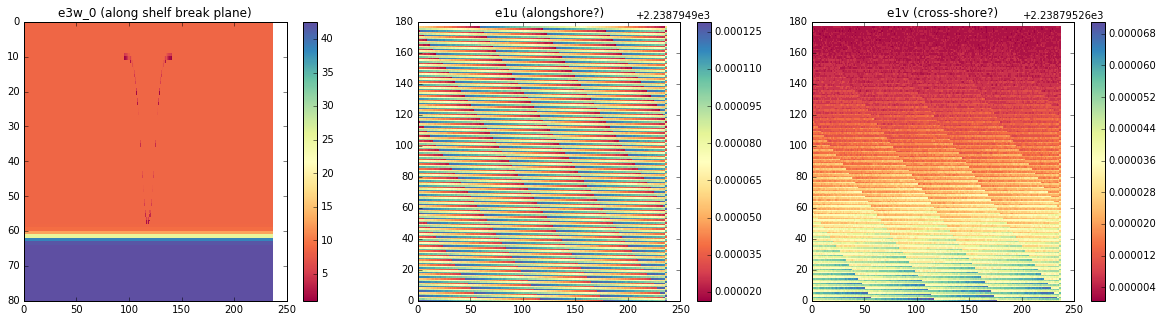

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
ax1.set_title('e3w_0 (along shelf break plane)')
ax2.set_title('e1u (alongshore?)')
ax3.set_title('e1v (cross-shore?)')

p1 = ax1.pcolor(e3w_0[:,ind_plane,:], cmap=cm.Spectral)
fig.colorbar(p1, ax=ax1)
ax1.invert_yaxis()

p2 = ax2.pcolor(e1u[:,:], cmap=cm.Spectral)
fig.colorbar(p2, ax=ax2)

p3 = ax3.pcolor(e1v[:,:], cmap=cm.Spectral)
fig.colorbar(p3, ax=ax3)

# Flux Containers

In [8]:
# depth closest to the shelf depth
depth_shelf_approx = 80
ind_shelf = np.argmin(np.abs(gdepw_1d - depth_shelf_approx))
depth_shelf = gdepw_1d[ind_shelf]
ind_plane = np.argmin(np.abs(bathy[:,0] - depth_shelf))

# bathymetry of plane at the shelf break
bathy_plane = bathy[ind_plane,:]

# depth closest to the bottom of the canyon
depth_canyon_approx = bathy_plane.max()
ind_canyon = np.argmin(np.abs(gdepw_1d - depth_canyon_approx))
depth_canyon = gdepw_1d[ind_canyon]

# canyon axis
ind_axis = np.where(bathy_plane == depth_canyon_approx)[0][0]

# finding the potential rim points
slope = abs(np.diff(bathy_plane))
ind_rimL0 = np.where(slope > 0.01)[0][0]
ind_rimR0 = np.where(slope > 0.01)[0][-1]

# index of the actual rim points
width_shelf = max(ind_rimR0 - ind_axis, ind_axis - ind_rimL0)
ind_rimL = ind_axis - width_shelf
ind_rimR = ind_axis + width_shelf

# adjacent containers with the same width
ind_shfL = ind_rimL - width_shelf
ind_shfR = ind_rimR + width_shelf

<a list of 1 text.Text objects>

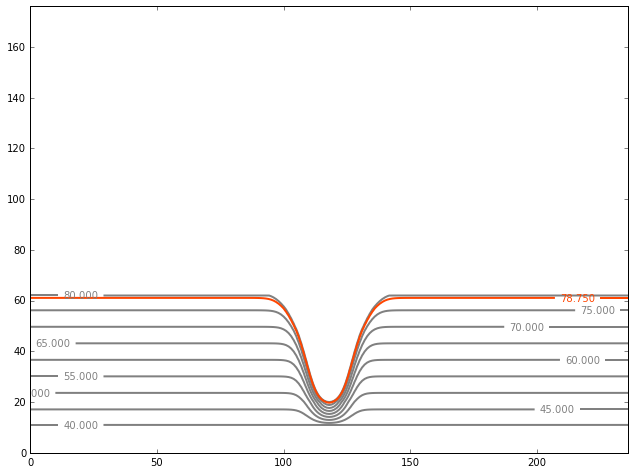

In [9]:
fig, ax = plt.subplots(1,1,figsize=(bathy.shape[1]/bathy.shape[0]*8, 8))
c = ax.contour(bathy[:,:], levels = np.arange(40,85,5), colors='gray', linewidths=2)
c1 = ax.contour(bathy[:,:], levels = [depth_shelf], colors='orangered', linewidths=2)
ax.clabel(c, inline=1, fontsize=10)
ax.clabel(c1, inline=1, fontsize=10)

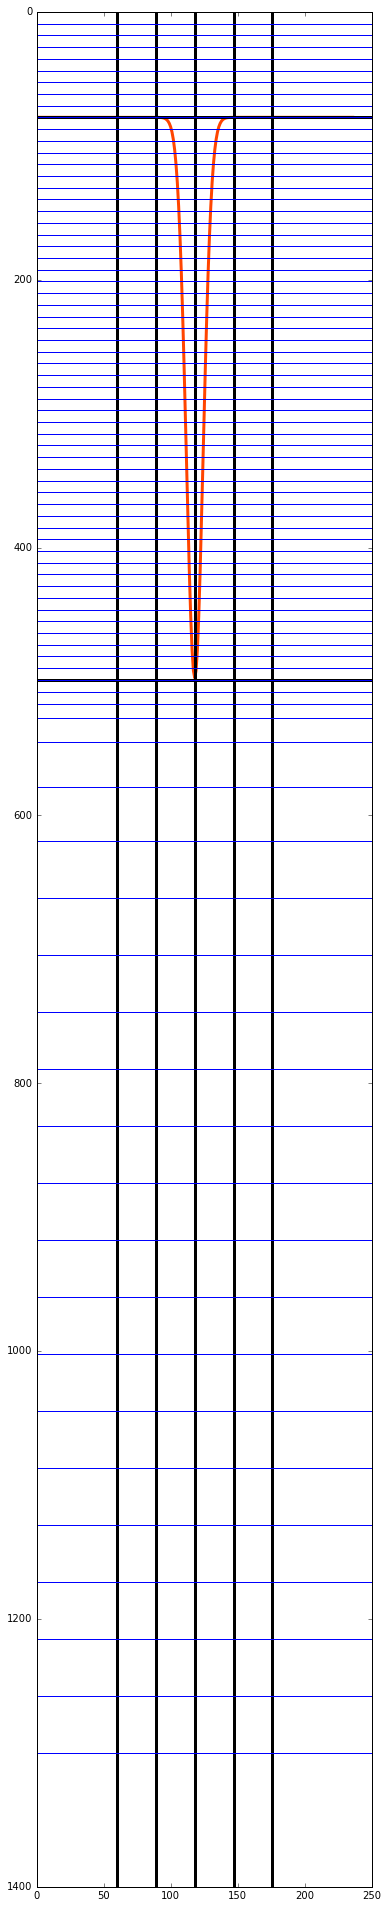

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,6*5.6))
ax.plot(bathy_plane, lw=3, c='orangered')
ax.invert_yaxis()

lw, c = 3, 'k'

ax.axhline(depth_shelf, c=c, lw=lw)
ax.axhline(depth_canyon, c=c, lw=lw)

ax.axvline(ind_axis, c=c, lw=lw)
ax.axvline(ind_rimL, c=c, lw=lw)
ax.axvline(ind_rimR, c=c, lw=lw)
ax.axvline(ind_shfL, c=c, lw=lw)
ax.axvline(ind_shfR, c=c, lw=lw)

for gdepw in zip(gdepw_1d):
    ax.axhline(gdepw, c='b', label = 'gdepw')